In [57]:
import pandas as pd
import numpy as np

In [58]:
!pip install -U keras-tuner



Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.2)


In [59]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [60]:
data.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [61]:
# dummy values for ocean_proximity
# data = pd.get_dummies(data,drop_first=True)
# data.isna().sum()

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [63]:
data['total_bedrooms'].isnull().any()

True

In [64]:
# Removing null values in 'total_bedrooms' with median value
median_bedrooms = data['total_bedrooms'].median()
data['total_bedrooms'].fillna(median_bedrooms,inplace=True)
data['total_bedrooms'].isnull().any()

False

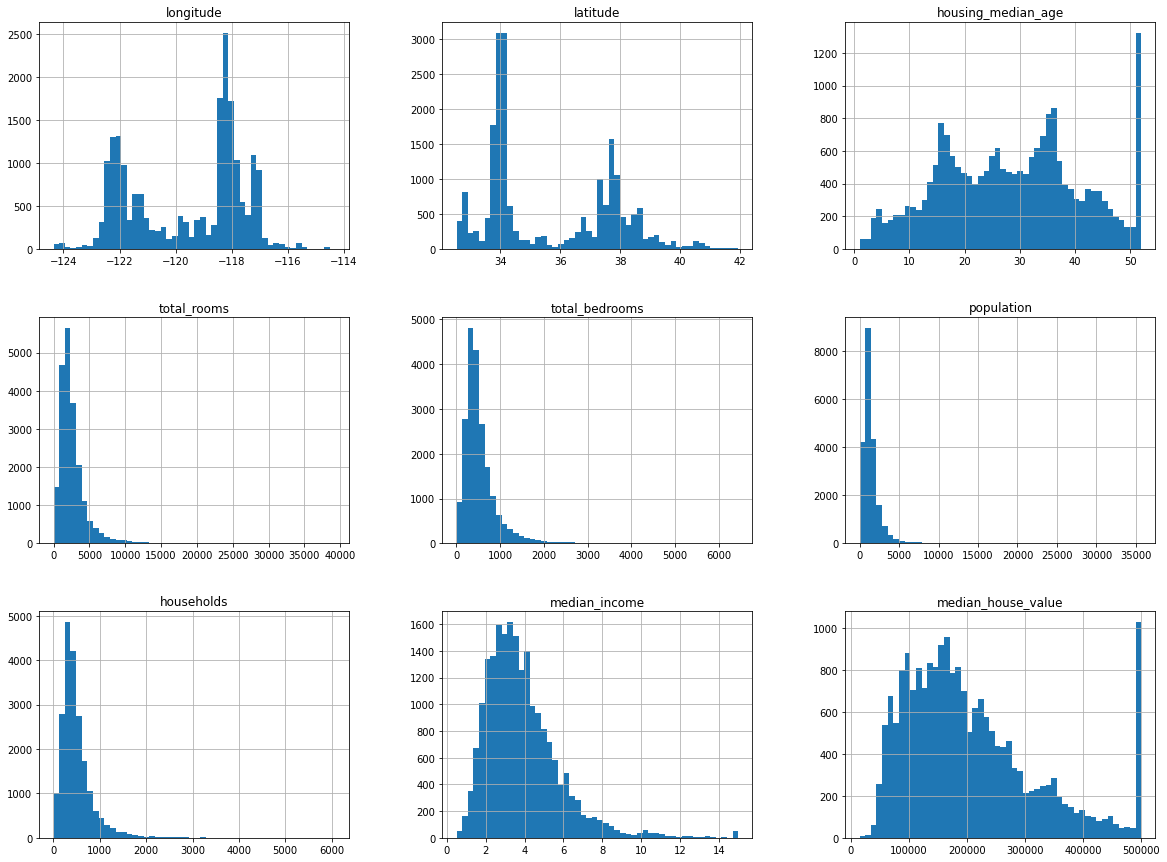

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

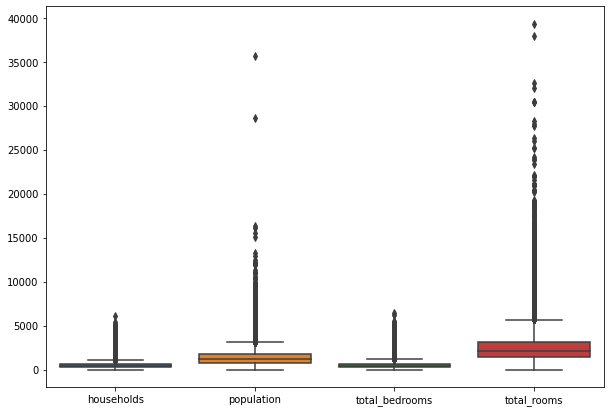

In [66]:
# Outliers
import seaborn as sns
columns = ['households','population','total_bedrooms','total_rooms']
plt.figure(figsize=(10,7))
sns.boxplot(data=data[columns])


In [67]:
# calculating number of outliers in data. (ignore that of ocean_proximity)
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3-Q1
High = (Q3) + 1.5*IQR
Low = (Q1) - 1.5*IQR

((data < Low) | (data > High)).sum()

households            1220
housing_median_age       0
latitude                 0
longitude                0
median_house_value    1071
median_income          681
ocean_proximity          0
population            1196
total_bedrooms        1306
total_rooms           1287
dtype: int64

In [68]:
corr = data.corr()
corr.style.background_gradient()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069120,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066484,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.319026,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.927058,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069120,-0.066484,-0.319026,0.927058,1.000000,0.873535,0.974366,-0.007617,0.049457
population,0.099773,-0.108785,-0.296244,0.857126,0.873535,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.974366,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007617,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049457,-0.024650,0.065843,0.688075,1.000000


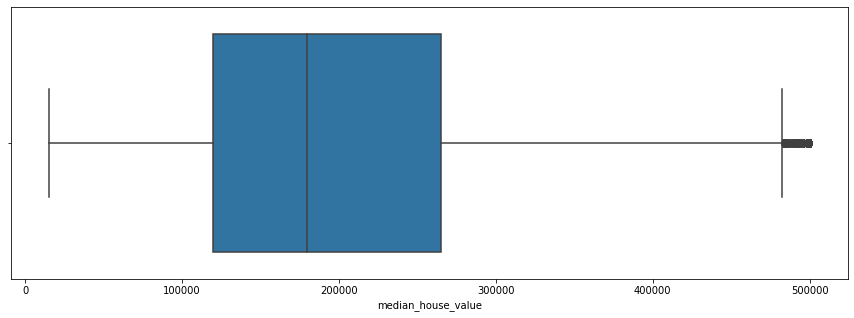

In [69]:

plt.figure(figsize=(15,5))
sns.boxplot(x=data['median_house_value'])

In [70]:
data = data.loc[data['median_house_value']<500001,:]


In [71]:
data.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [72]:
data['ocean_proximity'].value_counts()


<1H OCEAN     8604
INLAND        6524
NEAR OCEAN    2446
NEAR BAY      2096
ISLAND           5
Name: ocean_proximity, dtype: int64

In [73]:
def to_numbers(val):
    if val == '<1H OCEAN':
        return 0
    elif val == 'INLAND':
        return 1
    elif val == 'NEAR OCEAN':
        return 2
    elif val == 'NEAR BAY':
        return 3
    elif val == 'ISLAND':
        return 4
data['ocean_proximity'] = data['ocean_proximity'].apply(to_numbers)
data.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3


In [74]:
X=pd.DataFrame(columns=['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households',
                        'median_income','ocean_proximity'],data=data)
y=pd.DataFrame(columns=['median_house_value'],data=data)
print(X.shape,y.shape)

(19675, 9) (19675, 1)


In [ ]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,3


In [75]:
X.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
dtype: int64

In [76]:
#test train split
from sklearn.model_selection import train_test_split
X_train_full,X_test,y_train_full,y_test = train_test_split(X,y,random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=0)
print(X_train_full.shape,'  ',X_test.shape)
print(y_train_full.shape,'  ',y_test.shape)
print(X_train.shape,'  ',X_valid.shape)
print(y_train.shape,'  ',y_valid.shape)

(14756, 9)    (4919, 9)
(14756, 1)    (4919, 1)
(11067, 9)    (3689, 9)
(11067, 1)    (3689, 1)


In [77]:
y.to_numpy()

array([[452600.],
       [358500.],
       [352100.],
       ...,
       [ 92300.],
       [ 84700.],
       [ 89400.]])

In [78]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


In [79]:
X_train

array([[ 0.18091688, -0.67427494,  0.52934193, ...,  0.11851522,
        -0.29445857,  1.11511005],
       [ 0.71456479, -0.75817027,  0.37029576, ..., -0.08952938,
        -1.08061438, -0.91015013],
       [-1.45992578,  0.98964914,  1.56314203, ...,  0.2738903 ,
         0.18608674,  2.12774014],
       ...,
       [ 0.71456479, -0.71622261,  1.64266512, ..., -0.22120318,
         0.23690507, -0.91015013],
       [-1.44496369,  0.98032743,  1.40409586, ...,  1.60906262,
         0.89480509,  2.12774014],
       [ 0.60484279, -0.7069009 ,  1.00648044, ...,  0.36869544,
         0.35529014, -0.91015013]])

In [80]:
X_train.shape[1:]

(9,)

In [91]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
          metrics=['mean_absolute_error'])
    return model

In [92]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='Reg_ANN')

In [93]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [94]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test, y_test))

Trial 5 Complete [00h 02m 01s]
val_mean_absolute_error: 38438.01171875

Best val_mean_absolute_error So Far: 37903.895833333336
Total elapsed time: 00h 05m 09s
INFO:tensorflow:Oracle triggered exit


In [95]:
tuner.get_best_hyperparameters

<bound method BaseTuner.get_best_hyperparameters of <kerastuner.tuners.randomsearch.RandomSearch object at 0x7f58d25819e8>>

In [97]:
tuner.results_summary()

Results summary
Results in project/Reg_ANN
Showing 10 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 15
units_0: 384
units_1: 448
learning_rate: 0.001
units_2: 224
units_3: 160
units_4: 96
units_5: 352
units_6: 320
units_7: 128
units_8: 128
units_9: 288
units_10: 480
units_11: 288
units_12: 384
units_13: 32
units_14: 32
Score: 37903.895833333336
Trial summary
Hyperparameters:
num_layers: 11
units_0: 64
units_1: 448
learning_rate: 0.01
units_2: 224
units_3: 160
units_4: 32
units_5: 256
units_6: 192
units_7: 224
units_8: 160
units_9: 64
units_10: 256
units_11: 224
units_12: 416
Score: 38410.158854166664
Trial summary
Hyperparameters:
num_layers: 16
units_0: 512
units_1: 192
learning_rate: 0.0001
units_2: 352
units_3: 448
units_4: 512
units_5: 128
units_6: 128
units_7: 416
units_8: 480
units_9: 256
units_10: 480
units_11: 256
units_12: 352
units_13: 384
units_14: 448
units_15: 32
Score: 38438.01171875
Trial summary
Hyperpa

In [96]:

tuner.get_best_models()